In [53]:
import os
from typing import Annotated, TypedDict
from IPython.display import display, Image

from dotenv import load_dotenv
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain_community.tools import DuckDuckGoSearchRun
from langchain.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

In [57]:
load_dotenv()

search = DuckDuckGoSearchRun()

tools = [search]

LITE_LLM_API_KEY = os.getenv("OPENAI_API_KEY")
LITE_LLM_URL = os.getenv("OPENAI_BASE_URL")
LITE_MODEL = os.getenv("OPENAI_MODEL")

model = ChatOpenAI(
    model=LITE_MODEL, base_url=LITE_LLM_URL, api_key=LITE_LLM_API_KEY
).bind_tools(tools)


class ReasonerState(TypedDict):
    messages: Annotated[list, add_messages]
    agent_scratchpad: Annotated[list, add_messages]


def reasoner_agent(state: ReasonerState) -> ReasonerState:
    print(f"Model state: {state}")
    prompt_template = PromptTemplate.from_template(
        """
        You are reasoning through the data supplied to by the user

        You can utilize the following tools:
        def duckduckgo_search(query: str) -> Useful for when you need to answer questions about current events. Input should be a search query.

        Here are the steps you need to take:
        Question: User provided question
        Analyze: analyze what the user has given you and decide which tool to call
        Call Tool: call appropriate tool amongst the tools [duckduckgo_search]
        Reflect: is the information that has gotten enough?
        Analyze/Call Tool/Reflect can be called 5 times at most to get to the final answer
        Final Answer: When reasoning has stopped and you have the answer

        Begin!
        Question: {question}
        {agent_scratchpad}
        """
    )
    prompt = prompt_template.invoke(
        {"question": state["messages"][-1].content, "agent_scratchpad": ""}
    )
    print(f"Prompt: {prompt}")
    res = model.invoke(state["messages"])
    print("RESULT ->", res)
    return {"messages": [res.content]}


builder = StateGraph(ReasonerState)
builder.add_node("model", reasoner_agent)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "model")
builder.add_conditional_edges("model", tools_condition)
builder.add_edge("tools", "model")

graph = builder.compile()

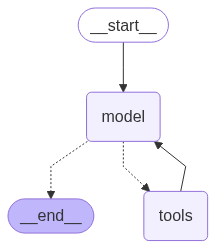

In [58]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [59]:
msg = {
    "messages": [
        HumanMessage(
            """How old was the 30th president of the United States
                        when he died?"""
        )
    ],
    "agent_scratchpad": [""],
}
for c in graph.stream(msg):
    print(c)

Model state: {'messages': [HumanMessage(content='How old was the 30th president of the United States\n                        when he died?', additional_kwargs={}, response_metadata={}, id='74f96ded-f7a7-4567-bb9b-6aa94bde8bcc')], 'agent_scratchpad': [HumanMessage(content='', additional_kwargs={}, response_metadata={}, id='77babc83-88bd-49f4-afef-97bc8aeefe5b')]}
Prompt: text='\n        You are reasoning through the data supplied to by the user\n\n        You can utilize the following tools:\n        def duckduckgo_search(query: str) -> Useful for when you need to answer questions about current events. Input should be a search query.\n\n        Here are the steps you need to take:\n        Question: User provided question\n        Analyze: analyze what the user has given you and decide which tool to call\n        Call Tool: call appropriate tool amongst the tools [duckduckgo_search]\n        Reflect: is the information that has gotten enough?\n        Analyze/Call Tool/Reflect can be c